In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

import time
import re, collections

import matplotlib.pyplot as plt

import tqdm
import os

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilisé : {device}")

Device utilisé : cuda


---
---
# Token 

In [33]:
class Tokenizer():
    """ This class is used to tokenize the input text and create a vocabulary of tokens. """
    def __init__(self, text, num_merges):
        self.text = text
        self.num_merges = num_merges

    def initialize_vocabulary(self, text):
        """ Initialize the vocabulary from the input text. """
        vocab = collections.defaultdict(int)
        words = text.strip().split()
        for word in words:
            vocab[' '.join(list(word)) + ' '] += 1
        return vocab
    
    def get_tokens_and_frequencies(self, vocab):
        """ Get the tokens and how often they occur in the vocabulary. """
        tokens = collections.defaultdict(int)
        for word, freq in vocab.items():
            word_tokens = word.split()
            for token in word_tokens:
                tokens[token] += freq
        return tokens
    
    def get_pairs_and_counts(self, vocab):
        """ Get the pairs of tokens and how often they occur in the vocabulary. """
        pairs = collections.defaultdict(int)
        for word, freq in vocab.items():
            symbols = word.split()
            for i in range(len(symbols)-1):
                pairs[symbols[i],symbols[i+1]] += freq
        return pairs
    
    def merge_pair_in_vocabulary(self, pair, vocab_in):
        """ Merge the most frequent pair of tokens in the vocabulary. """
        vocab_out = {}
        bigram = re.escape(' '.join(pair))
        p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
        for word in vocab_in:
            word_out = p.sub(''.join(pair), word)
            vocab_out[word_out] = vocab_in[word]
        return vocab_out
    
    def tokenize(self):
        """ Tokenize the input text. """
        if os.path.exists('./data/tokens_{}merges.pt'.format(self.num_merges)):
            print("Loading tokenized data from file")
            tokens = torch.load('./data/tokens_{}merges.pt'.format(self.num_merges),weights_only=False)
            vocab = torch.load('./data/vocab_{}merges.pt'.format(self.num_merges),weights_only=False)
            return tokens, vocab
        
        # Initialize the vocabulary from the input text
        vocab = self.initialize_vocabulary(self.text)

        # Merge the most frequent pair of tokens num_merges times
        with tqdm.tqdm(range(self.num_merges), position=0, leave=True) as pbar:
            for i in pbar:
                tokens = self.get_tokens_and_frequencies(vocab)
                pairs = self.get_pairs_and_counts(vocab)
                if not pairs:
                    break
                most_frequent_pair = max(pairs, key=pairs.get)
                vocab = self.merge_pair_in_vocabulary(most_frequent_pair, vocab)
                pbar.set_description(f'Num merges: {i + 1}')

        # Find the tokens and how often they occur in the vocabulary one last time
        tokens = self.get_tokens_and_frequencies(vocab)

        tokens[' '] = self.text.count(' ')
        tokens['\n'] = self.text.count('\n')

        torch.save(tokens, './data/tokens_{}merges.pt'.format(self.num_merges))
        torch.save(vocab, './data/vocab_{}merges.pt'.format(self.num_merges))

        return tokens, vocab


    def tokenize_text(self, tokens):
        """ Tokenize the input text using the tokens. """
        # Load tokenized data if it exists
        if os.path.exists('./data/tokenized_{}merges.pt'.format(self.num_merges)):
            print("Loading tokenized data from file")
            tokenized_text = torch.load('./data/tokenized_{}merges.pt'.format(self.num_merges),weights_only=False)
            return tokenized_text

        token_list = list(tokens.keys())
        tokenized_text = []  # List to store the tokenized text
        i = 0  # Index to keep track of the current position in the text

        print("Nombre de tokens trouvés :", len(token_list))

        with tqdm.tqdm(total=len(self.text), position=0, leave=True) as pbar:
            pbar.set_description("Tokenizing text")
            while i < len(self.text):
                match = None
                # loop through the tokens to find the longest match
                for token in sorted(token_list, key=len, reverse=True):
                    if self.text[i:i+len(token)] == token: 
                        match = token
                        break
                    
                if match:  
                    tokenized_text.append(match)
                    i += len(match)  # Move the index to the end of the token
                    pbar.update(len(match))
                else:
                    print("Token non trouvé pour le texte restant :", self.text[i:])
                    break 

        # Save the tokenized text
        torch.save(tokenized_text, './data/tokenized_{}merges.pt'.format(self.num_merges))
        return tokenized_text 

In [34]:
data = open('./shakespeare.txt', 'r').read()

In [35]:
tokenizer = Tokenizer(data, 1000)
tokens, vocab = tokenizer.tokenize()
tokenized_text = tokenizer.tokenize_text(tokens)

Loading tokenized data from file
Loading tokenized data from file


In [36]:
print(len(tokens))

1014


In [37]:
print(tokenized_text[:100])

['First', ' ', 'Citizen:', '\n', 'Be', 'fore', ' ', 'we', ' ', 'pro', 'ce', 'ed', ' ', 'any', ' ', 'f', 'ur', 'ther', ',', ' ', 'hear', ' ', 'me', ' ', 'speak', '.', '\n', '\n', 'All', ':', '\n', 'S', 'pe', 'ak', ',', ' ', 'speak', '.', '\n', '\n', 'First', ' ', 'Citizen:', '\n', 'You', ' ', 'are', ' ', 'all', ' ', 'res', 'ol', 'ved', ' ', 'ra', 'ther', ' ', 'to', ' ', 'die', ' ', 'than', ' ', 'to', ' ', 'fa', 'mis', 'h', '?', '\n', '\n', 'All', ':', '\n', 'R', 'es', 'ol', 'ved', '.', ' ', 'res', 'ol', 'ved', '.', '\n', '\n', 'First', ' ', 'Citizen:', '\n', 'First', ',', ' ', 'you', ' ', 'know', ' ', 'C', 'a', 'i']


---
---
# CharDataset

In [38]:
class CharDataset(Dataset):
    """ This class is used to create a PyTorch dataset from the tokenized text. """
    def __init__(self, tokenized_text, tokens, block_size = 32):

        chars = list(tokens.keys())

        self.stoi = {ch: i for i, ch in enumerate(chars)}
        self.itos = {i: ch for i, ch in enumerate(chars)}

        self.dataset = torch.tensor([self.stoi[ch] for ch in tokenized_text], dtype=torch.long)
        self.set_data_mode()

        
        self.vocab_size = len(chars)
        self.block_size = block_size


    def __len__(self):
        """ Return the number of blocks in the dataset, used by the DataLoader. """



        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        """ Return the input and target sequence. """
        chunk = self.data[idx:idx + self.block_size + 1]
        input_chunk = chunk[:-1]
        target = chunk[1:]
        return input_chunk, target

    def get_vocab_size(self):
        """ Return the size of the vocabulary. """
        return self.vocab_size

    def get_stoi(self):
        return self.stoi

    def get_itos(self):
        return self.itos
    
    def set_data_mode(self, train_mode = True):
        train_len = int(10/11 * len(self.dataset))

        if train_mode:
            self.data = self.dataset[:train_len]
        else:
            self.data = self.dataset[train_len:]

In [39]:
dataset = CharDataset(tokenized_text, tokens)

In [40]:
len(dataset.data)

520780

In [41]:
dataset.set_data_mode(train_mode = False)
len(dataset.data)

52078

---
---
# Positional Encoding


$$(sin(\theta), cos(\theta))$$
where 
$$\theta = \frac{t}{r^k},r = N^{2/d}$$

In [42]:
class PositionalEncoding(torch.nn.Module):
    """ This class is used to add positional encoding to the input embeddings. """
    def __init__(self, embedding_dim, max_len=10000):
        super(PositionalEncoding, self).__init__()

        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.pow(max_len ** (2/embedding_dim),-torch.arange(0, embedding_dim, 2))

        pe = torch.zeros(max_len, embedding_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0)) # add the batch dimension : buffer : ne sera pas modifié par le processus d'entrainement
    def forward(self, x):
        return self.pe[:, :x.size(1), :]

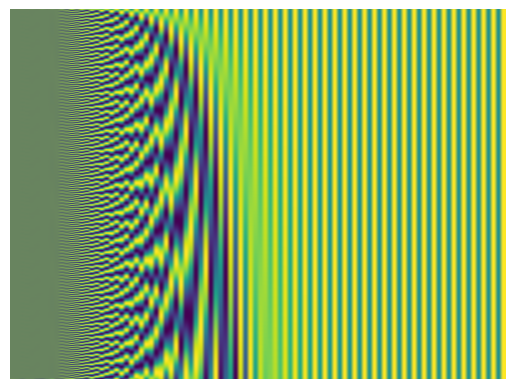

In [43]:
P = PositionalEncoding(100, max_len=10000)

plt.axis('off')
plt.imshow(P.pe.squeeze(0), aspect='auto')
plt.show()

---
---
# Attention

In [44]:
class CausalSelfAttention(nn.Module):
    def __init__(self, n_embd, n_head,n_red, dropout):
        super().__init__()
        self.test = n_red   # réduire la dimensionnalité de query et key
        self.n_head = n_head
        self.key = nn.Linear(n_embd, n_embd // self.test)
        self.query = nn.Linear(n_embd, n_embd // self.test)
        self.value = nn.Linear(n_embd, n_embd)
        #self.proj = nn.Linear(n_embd, n_embd) # Je ne suis pas sûr de cette ligne

        # empêchent le modèle de trop se concentrer sur un certain token durant l'entraînemen
        self.attn_drop = nn.Dropout(dropout)  # Will be used to help model not focusng on a specific token during training
        self.resid_drop = nn.Dropout(dropout)

        #  Cela enregistre un "mask" (un masque triangulaire inférieur) qui est utilisé dans l'attention causale pour éviter que chaque position d'un token puisse voir les futurs tokens.
        self.register_buffer("mask", torch.tril(torch.ones(1024, 1024)).view(1, 1, 1024, 1024))

    def forward(self, x):
        B, T, C = x.size()

        q, k, v = self.query(x), self.key(x), self.value(x)

        # 
        q = q.view(B, T, self.n_head, C // (self.test*self.n_head)).transpose(1, 2)
        k = k.view(B, T, self.n_head, C // (self.test*self.n_head)).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        
        att = (q @ k.transpose(-2, -1)) * (1.0 / (k.size(-1) ** 0.5))  # scaling
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))  # application du masque
        att = nn.functional.softmax(att, dim=-1)    # normalisation
        att = self.attn_drop(att)                   # éviter surapprentissage
        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_drop(y)
        return y

---
---
# Transformer block

In [45]:
class TransformerBlock(nn.Module):
    """ This class is used to define a transformer block wich is self attention followed by a feed forward neural network. """
    def __init__(self, n_embd, n_head, n_red, dropout, factor=4):
        super().__init__()
        self.attention = CausalSelfAttention(n_embd, n_head, n_red, dropout)
        self.mlp = nn.Sequential(
            nn.Linear(n_embd, n_embd * factor),
            nn.ReLU(),
            nn.Linear(n_embd * factor, n_embd),  
            nn.Dropout(dropout)
        )
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
    

    #
    def forward(self, x):
        x = x + self.attention(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

---
---
# GPT

In [46]:
class GPT(nn.Module):
    """ This class is used to define the GPT model. """
    def __init__(self, vocab_size, block_size, n_embd, n_layer, n_head,n_red, dropout=0.2):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, n_embd) # Embedding layer
        self.position_embedding = PositionalEncoding(n_embd)
        self.layers = nn.ModuleList([ # List of transformer blocks
            TransformerBlock(n_embd, n_head,n_red, dropout) for _ in range(n_layer)
        ])
        self.layer_norm = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size) # Output layer to predict the next token

    def forward(self, idx):
        B, T = idx.size()
        tok_emb = self.token_embedding(idx)
        pos_emb = self.position_embedding(idx)
        x = tok_emb + pos_emb
        for layer in self.layers:
            x = layer(x)
        x = self.layer_norm(x)
        logits = self.lm_head(x)
        return logits

---
---
# Validation Loss

In [47]:
def current_loss(model, dataset, batch_size, device,numpasses,Train_mode = True):
    model.to(device)
    model.eval()
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    total_loss = 0
    count = 0

    dataset.set_data_mode(Train_mode)

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            logits = model(inputs)
            logits = logits.view(-1, logits.size(-1))
            targets = targets.view(-1)
            loss = F.cross_entropy(logits, targets)
            total_loss += loss.item()
            
            count += 1
            if count >= numpasses:
                break

    
    dataset.set_data_mode()
    return total_loss / numpasses

---
---
# Train function

In [48]:
def train_wrt_iters(model, dataset, batch_size, max_iters, lr, device,letter):

    model.to(device)

    iters = 0
    train_losses = []
    test_losses = []

    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True)

    with tqdm.tqdm(total=max_iters, position=0, leave=True) as pbar:
        for inputs, targets in dataloader:

            inputs, targets = inputs.to(device), targets.to(device)

            logits = model(inputs)

            logits = logits.view(-1, logits.size(-1))
            targets = targets.view(-1)

            optimizer.zero_grad()
            loss = F.cross_entropy(logits, targets)
            loss.backward()

            optimizer.step()

            if iters % 100 == 0:
                train_losses.append(current_loss(model, dataset,batch_size, device,10))
                test_losses.append(current_loss(model, dataset,batch_size, device,10,Train_mode = False))

            if iters % 1000 == 0:
                torch.save(model.state_dict(), './saved_models/{}model_{}.pt'.format(letter,iters))

            iters += 1
            if iters > max_iters:
                break

            
            pbar.update()
    return train_losses, test_losses

In [ ]:
# PARAMETERS SAVING FUNCTION
import json
def save_params(file_path, params: dict, force=False):
    if not force and os.path.exists(file_path):
        raise FileExistsError("File already exists")
        
    file = open(file_path, 'w', encoding='utf-8')
    json.dump(params, file)
    file.close()

def load_params(file_path):
    file = open(file_path, 'r', encoding='utf-8')
    data = json.load(file)
    file.close()

    return data

---
---
# Acuracy function

In [ ]:
def Accuracy(model , dataset,train_data = False, second_best = False):
    model.to(device)
    model.eval()
    dataset.set_data_mode(train_mode= train_data)
    correct = 0
    total = 0
    t0 = time.time()
    dataloader = DataLoader(dataset, batch_size=100, shuffle=True, pin_memory=True)
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            logits = model(inputs)
            logits = logits.view(-1, logits.size(-1))
            targets = targets.view(-1)
            
            _, predicted = torch.max(logits, 1)
            correct += (predicted == targets).sum().item()

            if second_best :
                logits[:,predicted] = -float('inf')
                _, predicted2 = torch.max(logits, 1)
                correct += (predicted2 == targets).sum().item()

            total += targets.size(0)
            if time.time() - t0 > 4:
                break

    return round(correct / total, 2)

---
---
# Generate function

In [51]:
# Text generation function
def generate_text(model, start_text, length, stoi, itos, block_size, device):
    model.eval()
    context = torch.tensor([stoi[c] for c in start_text], dtype=torch.long, device=device).unsqueeze(0)
    generated = context.tolist()[0]
    with torch.no_grad():
        for _ in range(length):
            logits = model(context)
            logits = logits[:, -1, :]
            probs = nn.functional.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1).item()
            generated.append(next_token)
            context = torch.tensor(generated[-block_size:], dtype=torch.long, device=device).unsqueeze(0)
    return ''.join(itos[i] for i in generated)

---
---
# Training our model

In [ ]:
# Configurations
block_size = 128

batch_size = 64

n_red = 1

n_embd = 2*384  # Attention : n_reduction * n_head doit diviser n_embd

n_layer = 8
n_head = 6   # Nombre de têtes d'attention (N'affecte pas la vitesse)
n_steps = 6000
lr = 3e-4

# Initialisation du modèle
model = GPT(vocab_size=len(tokens), block_size=block_size, n_embd=n_embd, n_layer=n_layer, n_head=n_head,n_red=n_red)

dataset = CharDataset(tokenized_text, tokens, block_size=block_size)

nb_params = sum([param.view(-1).size()[0] for param in model.parameters()])

print(f"Nombre de paramètres du modèle : {nb_params}")

Nombre de paramètres du modèle : 53538294


In [54]:
letter = 'c'

state_params_saver = {
    'block_size': block_size,
    'batch_size': batch_size,
    'n_red': n_red,
    'n_emb': n_embd,
    'n_layer': n_layer,
    'n_head': n_head,
    'vocab_size': len(vocab)
}

# saving parameters
file_path = f"./saved_models/{letter}_models_params.json"

save_params(file_path, state_params_saver, force=True)

In [ ]:
train_losses, test_losses = train_wrt_iters(model, dataset, batch_size, n_steps, lr, device,letter)

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('gradient steps / 100')
plt.ylabel('Loss')

plt.title('Train and Test Loss for n_embd = 768, n_head = 6')

plt.legend()
plt.show()

---
---
# Evaluating the model

In [ ]:
model.load_state_dict(torch.load('./saved_models/large_128-64-1-120-6-6model_2000.pt',weights_only=True))
model_1000_steps = model.to(device)

seed = "Sedric"
print(generate_text(model_1000_steps,seed,300,dataset.stoi,dataset.itos,block_size = block_size,device = device))

In [ ]:
print("For 1000 steps : ")
print("Accuracy on test data : ",100*Accuracy(model_1000_steps, dataset,train_data = False))
print("Accuracy on train data : ",100*Accuracy(model_1000_steps, dataset,train_data = True))

In [ ]:
model.load_state_dict(torch.load('./saved_models/cmodel_6000.pt',weights_only=True))
model_6000_steps = model.to(device)

seed = "To be, or not to be: "
print(generate_text(model_6000_steps,seed,300,dataset.stoi,dataset.itos,block_size = block_size,device = device))

In [ ]:
print("For 6000 steps : ")
print("Accuracy on test data : ",100*Accuracy(model_6000_steps, dataset,train_data = False))
print("Accuracy on train data : ",100*Accuracy(model_6000_steps, dataset,train_data = True))

In [ ]:
model.load_state_dict(torch.load('./saved_models/cmodel_2000.pt',weights_only=True))
model_2000_steps = model.to(device)

seed = "To be, or not to be: "
print(generate_text(model_2000_steps,seed,300,dataset.stoi,dataset.itos,block_size = block_size,device = device))

In [ ]:
print("For 2000 steps : ")
print("Accuracy on test data : ",100*Accuracy(model_2000_steps, dataset,train_data = False))
print("Accuracy on train data : ",100*Accuracy(model_2000_steps, dataset,train_data = True))